<a href="https://colab.research.google.com/github/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [69]:
# Platform Interface
import time
from time import sleep
import requests
import pickle
import os

import pandas as pd
import numpy as np
import random
import itertools

# Visualisation Libraries
# !pip install --upgrade --quiet witwidget lime
# import lime
# import shap
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# ML Libraries
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer , TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve , confusion_matrix , roc_curve
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
import tensorflow_hub as hub

!pip3 install --quiet tensorflow-text
import tensorflow_text as text


pd.set_option('display.max_colwidth' , 300)

In [3]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [4]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [5]:
def ngram_generator(df , ngram , subreddit = None):
  
  """
  This function contains 2 actions in order to process the word into visualiation base on the ngram count.
  1. CountVectorize & Transform Data
  2. Convert Data back to Matrix
  """
  
  if subreddit == None:
    cvec = CountVectorizer(ngram_range=(ngram,ngram))
    cvec.fit(df['title'])
    transformed = cvec.transform(df['title'])

  if subreddit == 'fake':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 0]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 0]['title'])

  elif subreddit == 'world':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 1]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 1]['title'])

  df_transformed = pd.DataFrame(transformed.todense(),
                                columns = cvec.get_feature_names())
  
  return df_transformed

In [42]:
def ngram_visualizer(df1 , df2 , df3):

  '''
  df1 = Main DF
  df2 = Fakenews
  df3 = Worldnews
  '''
  fig , ax = plt.subplots(1 , 3 , figsize = (24,10))

  df1.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[0])
  ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

  df2.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[1] , color = 'lightblue')
  ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

  df3.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[2] , color = 'green')
  ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

In [7]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [8]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [9]:
def tf_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [92]:
def plot_roc_curve_keras(model , X_test , y_test): 

  y_proba = model.predict(X_test).ravel()

  fpr , tpr , thresholds = roc_curve(y_test , y_proba)

  plt.plot(fpr,tpr) 
  plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    

In [10]:
# df_fakenews = red_scrap('fakenews')

In [11]:
# df_worldnews = red_scrap('worldnews')

In [12]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [13]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv

--2021-09-24 06:53:18--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3523846 (3.4M) [text/plain]
Saving to: ‘fakenews.csv’

fakenews.csv        100%[===================>]   3.36M  --.-KB/s    in 0.02s   

2021-09-24 06:53:18 (159 MB/s) - ‘fakenews.csv’ saved [3523846/3523846]

--2021-09-24 06:53:18--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reques

In [14]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [15]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1400
Shape of World News Datasets : (1400, 3)


### 1.1 Checking for Duplicates and Null
___

In [16]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)
print(f'No. of Duplicate Cell After Remove Duplicate : {df_fakenews.duplicated().sum()}')

No. of Duplicate Cell : 1
No. of Null Cell : 0
No. of Duplicate Cell After Remove Duplicate : 0


In [17]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [18]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 It's a WhatsApp forwarded message which is mentioning happend on vatican plz fact check
1 Webinar on how fake news will affect key Presidential and Congressional elections this November
2 Mexican beer rebrands as Ebola to avoid association with coronavirus
3 Bill Gates VS David Icke - EPIC Conspiracy Theory SHOW DOWN
4 Youtuber Goes Unconsious on Stream
5 A bit of satire making fun of the fake news media
6 From r/conservative, can't tell if sarcasm is being used here...
7 Can i trust this newspaper?Your experience?
8 Annoyed by this video - NSFW
9 One in Every 10 Europeans Has Bought a Fake Product: Study


In [19]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Lebanon government to be announced Friday, PM-designate tells local media
1 The Museum of Contemporary Art in Los Angeles Names a Co-Leader
2 CNBC poll shows very little will persuade unvaccinated Americans to get Covid shots
3 Afghani Central Bank "Governor" image goes viral. But it’s a fake, original posted by an advertising company founder.
4 Look out beautiful Taj Mahal || TAJ MAHAL VIDEO || VIDEO CLIP
5 “Having a luck dragon with you is the only way to go on a quest” -Falcore
6 Autistic Boy in Utah in Critical Condition After Being Shot by Police
7 Residência de Estudantes Santa Apolónia / Pereira Miguel Arquitectos
8 US fires destroy five towns, deaths feared
9 #BBIG is the play. Gamma begins tomorrow with over 40k call options itm Buy BBIG and hold for the $$$🚀🚀🚀🚀


# 2.0 Data Cleaning and Preprocessing
___

In [20]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [21]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  The Anti HCQ Study Is Now Being Called Fake News, So Trump Was Right??!
Remove Numeric , lowercase       :  ['the', 'anti', 'hcq', 'study', 'is', 'now', 'being', 'called', 'fake', 'news', 'so', 'trump', 'was', 'right']
Remove Punctuation               :  ['the', 'anti', 'hcq', 'study', 'is', 'now', 'being', 'called', 'fake', 'news', 'so', 'trump', 'was', 'right']
Remove Stop words                :  ['anti', 'hcq', 'study', 'called', 'fake', 'news', 'trump', 'right']
Stem the words & joint the words :  anti hcq studi call fake news trump right
-----------------------------------------
Original Sentence                :  Did You Know That Fake News Is Not New? (Article link in comments.)
Remove Numeric , lowercase       :  ['did', 'you', 'know', 'that', 'fake', 'news', 'is', 'not', 'new', 'article', 'link', 'in', 'comments']
Remove Punctuation               :  ['did', 'you', 'know', 'that', 'fake', 'news', 'is', 'not', 'new', 'article', 'link', 'in', '

### 2.2 Preprocess Function for data
___

In [22]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [23]:
preprocessing(df_fakenews , 'title')

In [24]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [25]:
preprocessing(df_worldnews , 'title')

In [26]:
df_worldnews.head()

,title,subreddit,created_utc
0,mari trump say disgrac uncl spend comment box match,worldnews,2021-09-12 06:20:04
1,next fast food chicken sandwich war may fake one,worldnews,2021-09-12 06:11:44
2,revis belgium histori call first ebola outbreak congo,worldnews,2021-09-12 06:00:46
3,democrat build big edg earli vote,worldnews,2021-09-12 05:59:43
4,ch51 ch51,worldnews,2021-09-12 05:59:42


### 2.3 Merging Datasets
___

In [27]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 2899
Shape of Combined Datasets : (2899, 2)
SIze of Combined Datasets : 5798


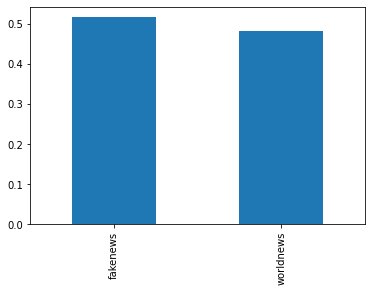

In [28]:
df_main['subreddit'].value_counts(normalize = True).plot(kind = 'bar');

In [29]:
dict_reddit = {'fakenews' : 0,
               'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

### 2.4 Removing Sentence with less than 2 word
___

In [30]:
df_main['len of sentence'] = [len(sentence.split(' ')) for sentence in df_main['title']]

In [31]:
print('No. of Sentence with 1 word :' , len(df_main[df_main['len of sentence'] == 1]))
print('Longest Sentence :' , df_main['len of sentence'].max())
df_main[df_main['len of sentence'] == 1].head(10)

No. of Sentence with 1 word : 140
Longest Sentence : 46


,title,subreddit,len of sentence
11,,0,1
31,hhhmmm,0,1
40,propaganda,0,1
58,reddit,0,1
116,guid,0,1
157,make,0,1
166,cnn,0,1
193,,0,1
220,real,0,1
245,world,0,1


In [32]:
df_main = df_main[df_main['len of sentence'] > 2]

In [33]:
# !pip install unidecode
# import unidecode

### 2.5 Visualising Popular Words
___

In [34]:
# Inistantiating Count Vectorizer
cvec = CountVectorizer(ngram_range=(1,3))
cvec.fit(df_main['title'])
main = cvec.transform(df_main['title'])

cvec_fake = CountVectorizer(ngram_range = (1,3))
cvec_fake.fit(df_main[df_main['subreddit'] == 0]['title'])
fake = cvec_fake.transform(df_main[df_main['subreddit'] == 0]['title'])

cvec_world = CountVectorizer(ngram_range = (1,3))
cvec_world.fit(df_main[df_main['subreddit'] == 1]['title'])
world = cvec_world.transform(df_main[df_main['subreddit'] == 1]['title'])

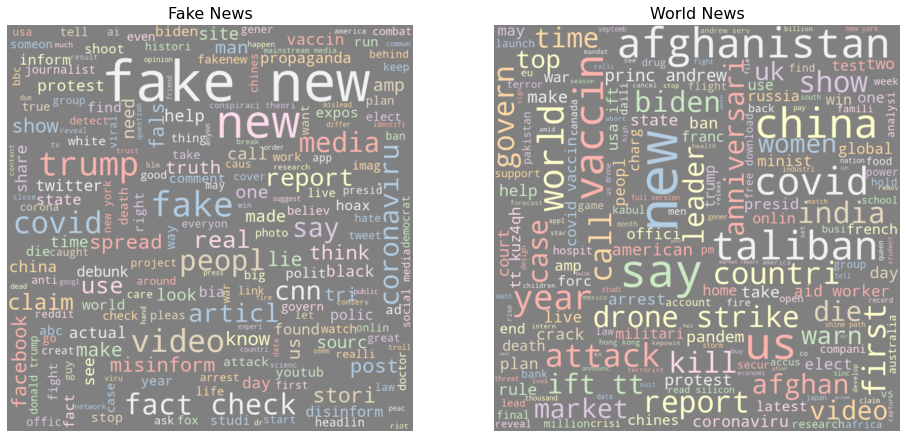

In [35]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                          height= 800,
                          max_font_size = 110,
                          collocations = True,
                          background_color = 'grey',
                          colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                            height= 800,
                            max_font_size = 110,
                            collocations = True,
                            background_color = 'grey',
                            colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [36]:
# Interestingly the vocab from each DF summed up is not equal to the vocab from the merged DF
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())

df_fake_vocab = pd.DataFrame(fake.todense(),
                             columns = cvec_fake.get_feature_names())

df_world_vocab = pd.DataFrame(world.todense(),
                              columns = cvec_world.get_feature_names())

print(f'DF Shape for Main Vocab :' , df_main_vocab.shape)
print(f'DF Shape for fakenews Vocab  :' , df_fake_vocab.shape)
print(f'DF Shape for worldnews Vocab  :' , df_world_vocab.shape)

DF Shape for Main Vocab : (2605, 38597)
DF Shape for fakenews Vocab  : (1293, 19458)
DF Shape for worldnews Vocab  : (1312, 20943)


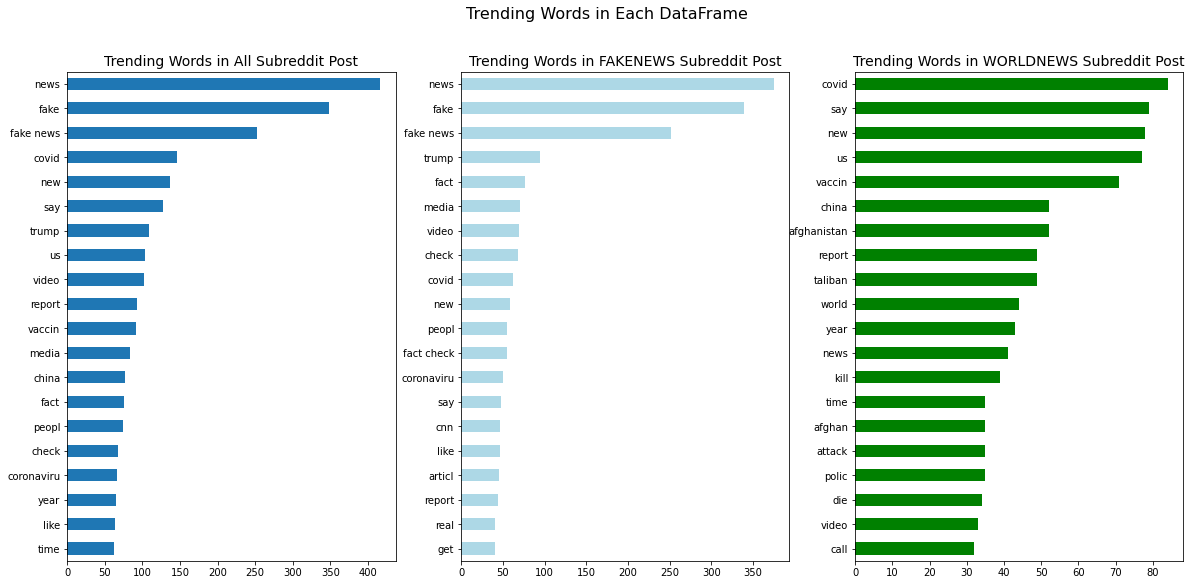

In [43]:
fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

df_main_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

df_fake_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

df_world_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

plt.suptitle('Trending Words in Each DataFrame' , fontsize = 16);

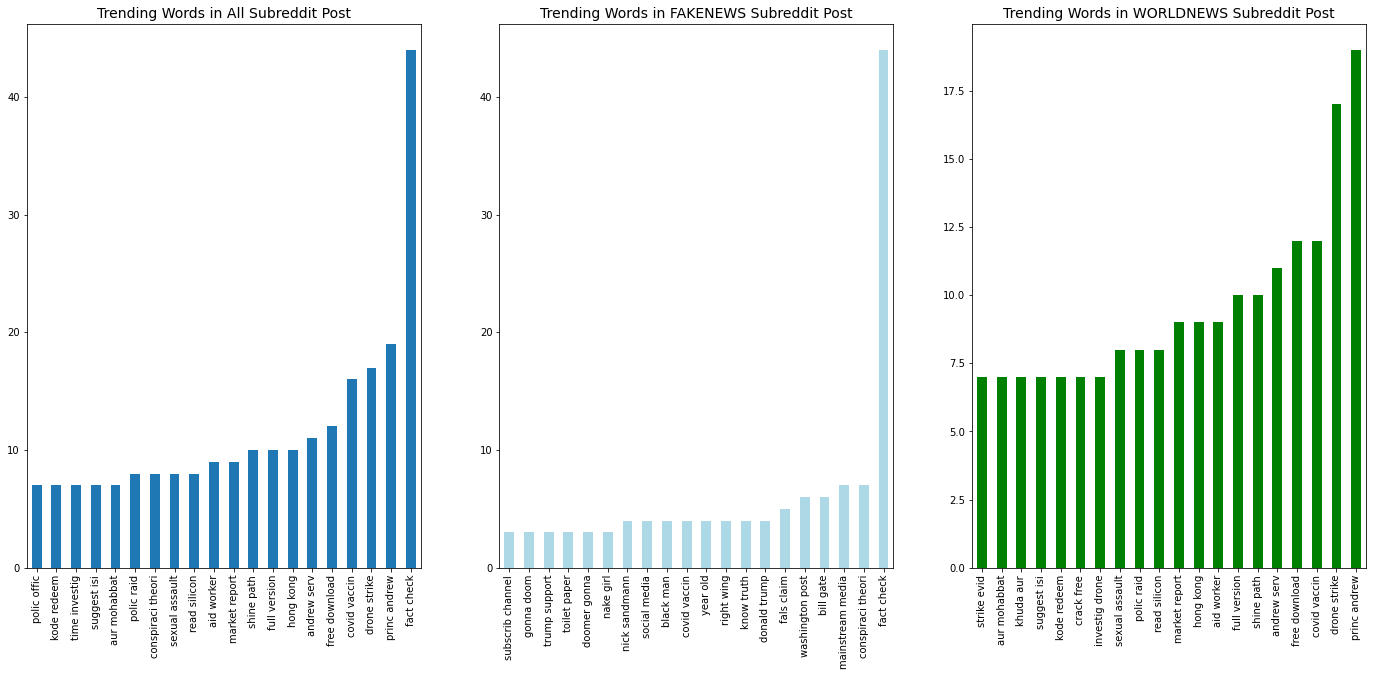

In [44]:
df_main_vocab_n2 = ngram_generator(df_main , 2)
df_world_vocab_n2 = ngram_generator(df_main , 2 , 'world')
df_fake_vocab_n2 = ngram_generator(df_main , 2 , 'fake')

ngram_visualizer(df_main_vocab_n2 , df_fake_vocab_n2 , df_world_vocab_n2)

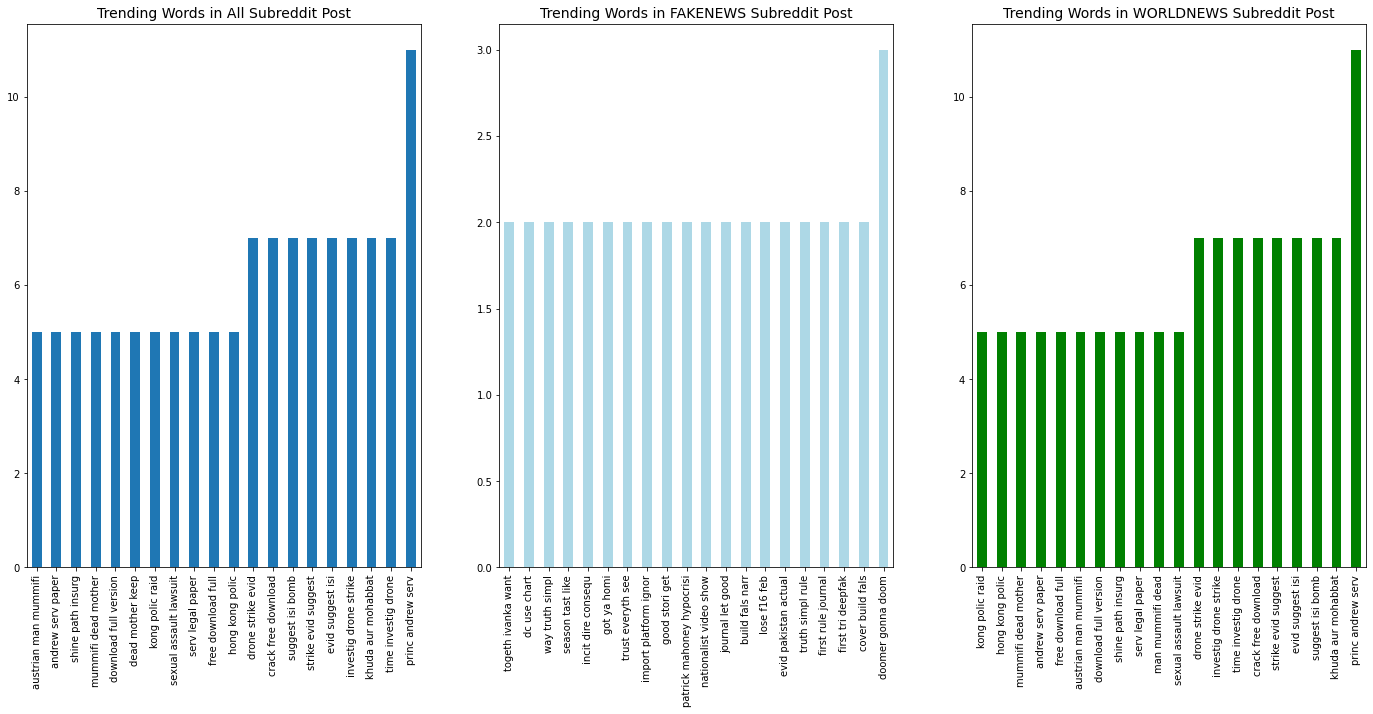

In [45]:
df_main_vocab_n3 = ngram_generator(df_main , 3)
df_world_vocab_n3 = ngram_generator(df_main , 3 , 'world')
df_fake_vocab_n3 = ngram_generator(df_main , 3 , 'fake')

ngram_visualizer(df_main_vocab_n3 , df_fake_vocab_n3 , df_world_vocab_n3)

### 2.6 Removing Data Leakage
___

In [46]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_main))
df_main = df_main.loc[~df_main['title'].str.contains('fake|news|new|say|http|ift|https')]
df_main.head()
print('Data Count After removal leaked words:' , len(df_main))

Data Count Before removal leaked words: 1847
Data Count After removal leaked words: 1847


### 2.7 Splitting Data
___

In [47]:
X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42 , stratify = y)

print('X_train Shape : ' , X_train.shape)
print('X_test Shape : ' , X_test.shape)
print('y_train Shape : '  , y_train.shape)
print('y_test Shape : ' , y_test.shape)

X_train Shape :  (1477,)
X_test Shape :  (370,)
y_train Shape :  (1477,)
y_test Shape :  (370,)


### 2.8 Checking for Data Imbalance
___

After removing leaked words and aplitting the dataset , the dataset between Fakenews and World News is quite evenly split between Fake and World News at 42% to 57%. We will not smote the dataset in this run.

In [53]:
# We Have Imbalance Data , need to SMOTE before that.
print(f' Fake News % : {y.value_counts(normalize=True)[0]*100}')
print(f' World News % : {y.value_counts(normalize=True)[1]*100}')

 Fake News % : 42.230644288034654
 World News % : 57.76935571196535


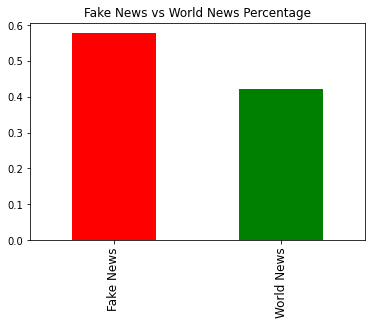

In [51]:
ax = y.value_counts(normalize=True).plot(kind = 'bar' , color = ['red' , 'green'])
ax.set_xticklabels(['Fake News' , 'World News'],fontsize=12);
ax.set_title('Fake News vs World News Percentage');

#3.0 Modelling with Random Forest

In [ ]:
# %%time
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', RandomForestClassifier())
# ])

# # rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
# #                  'min_samples_leaf' : np.arange(1, 5 , 1),
# #                  'n_estimators' : np.arange(50 , 80 , 10),
# #                  'max_features' : ['log2' , 'sqrt' , 'auto'],
# #                  'max_depth' : [None , 3 , 5]}

# param_grid = {'vect__ngram_range' : [(1,1) , (1,2) , (1,3)],
#               'tfidf__smooth_idf' : [True , False],
#               'tfidf__sublinear_tf' : [True , False],
#               'model__min_samples_split' : np.arange(2 , 10 , 2),
#               'model__min_samples_leaf' : np.arange(1 , 5 , 1),
#               'model__n_estimators' : np.arange(50 , 80 , 10),
#               'model__max_features' : ['log2' , 'sqrt' , 'auto'],
#               'model__max_depth' : [3,5,7]              
# }

# # Fitting the model
# model = GridSearchCV(estimator = pipe,
#                      param_grid = param_grid,
#                      cv = 5,
#                      n_jobs =-1)

# model.fit(X_train , y_train)
# # # Model Prediction
# y_pred = model.predict(X_test)

In [ ]:
# model.best_params_

In [ ]:
# # Saving the Model
# pickle.dump(model , open('RFC_model.pkl' , 'wb'))

In [1]:
# !wget https://github.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/saved_models/RFC_model.pkl

### 3.1 Fine Tuning Grid Search Parameter
___

In [ ]:
# %%time
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', RandomForestClassifier())
# ])

# # rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
# #                  'min_samples_leaf' : np.arange(1, 5 , 1),
# #                  'n_estimators' : np.arange(50 , 80 , 10),
# #                  'max_features' : ['log2' , 'sqrt' , 'auto'],
# #                  'max_depth' : [None , 3 , 5]}

# param_grid = {'vect__min_df' : range(5,10),
#               'vect__max_df' : np.arange(0.90 , 1.0 , 0.1),
#               'model__min_samples_split' : np.arange(1 , 5 , 1),
#               'model__min_samples_leaf' : np.arange(6 , 8 , 1),
#               'model__n_estimators' : np.arange(90 , 120 , 10),
#               'model__max_features' : ['sqrt'],
#               'model__max_depth' : [None]              
# }

# # Fitting the model
# model_2 = GridSearchCV(estimator = pipe,
#                        param_grid = param_grid,
#                        cv = 5,
#                        n_jobs =-1)

# model_2.fit(X_train , y_train)
# # # Model Prediction
# y_pred_2 = model_2.predict(X_test)

In [ ]:
# model_2.best_params_

In [54]:
model_RFC = Pipeline([('vect', CountVectorizer(min_df = 5 , max_df = 0.90 , ngram_range = (1,1))),
                      ('tfidf', TfidfTransformer('l2')),
                      ('model', RandomForestClassifier(min_samples_split= 3,
                                                       min_samples_leaf = 6,
                                                       n_estimators = 110,
                                                       max_features = 'sqrt'))
])


model_RFC.fit(X_train , y_train)
model_RFC_pred = model_RFC.predict(X_test)

### 3.2 Evaluating Random Forest Classifier Model Score
___

{'Accuracy': 0.7675675675675676,
 'F1 Score': 0.8208333333333333,
 'Precision': 0.7406015037593985,
 'Recall': 0.9205607476635514}

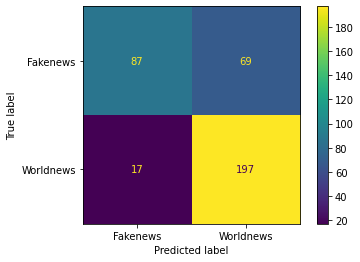

In [126]:
plot_confusion_matrix(model_RFC , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

rfc_score = eval_classification(y_true=y_test , y_pred = model_RFC_pred)
rfc_score

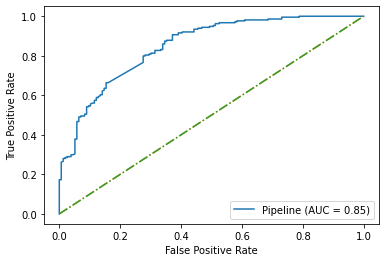

In [57]:
rfc_plot = plot_roc_curve(model_RFC , X_test , y_test)
plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');

### 3.3 Visualing Most Wrongly Predicted Reddit Post
___

In [ ]:
y_proba = model_RFC.predict_proba(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]
worldnews_prediction = [y_proba[i][1] for i in range(len(X_test))]

In [ ]:
df_prediction  = pd.DataFrame({'Title' : X_test,
                              'Target' : y_test,
                              'Prediction' : model_RFC_pred,
                              'Fakenews_score' : fakenews_prediction,
                              'Worldnews_score' : worldnews_prediction})

In [ ]:
# Visualing Most Wrong World News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_score' , ascending = False).drop('Worldnews_score' , axis = 1)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Fakenews_score
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0,0.753214
1123,girl rescu famili tri goug eye cannibalist black magic ritual coconut jakarta,1,0,0.734482
1069,pakistan report fresh coronaviru case death,1,0,0.702001
10,ben affleck push intrus fan tri click selfi jennif lopez venic airport,1,0,0.696135
1346,facebook apolog put primat label video black men,1,0,0.694154
1012,lebanon govern announc friday pm design tell local media,1,0,0.580764
872,orfium project offic elstudio,1,0,0.580714
710,btc giveaway promot like page comment btc address,1,0,0.580619
568,happen gener facebook websit xml sitemap file,1,0,0.565528
1199,singapor paus reopen expert suggest bolder covid strategi,1,0,0.547229


In [ ]:
# Visualing Most Wrong fake News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Worldnews_score' , ascending = False).drop('Fakenews_score' , axis = 1)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Worldnews_score
261,pocahonta first winner hunger game,0,1,0.816675
74,afghan ambassador daughter bruis blood mark real,0,1,0.768139
1486,misconcept cast system india,0,1,0.751472
373,due covid travel restrict american forc hold coup local year,0,1,0.736284
405,zombi fliegen dänemark entdeckt soll ja bald auch auf den menschen bertragbar sein wobei der pilz dann wohl nicht die genitalien de wirt frisst sondern sein gehirn können all querdenk und coronaleugn aufatmen,0,1,0.733717
32,one day fewer hospit make trend especi less decreas,0,1,0.726901
1330,thai seal murder cave rescu cover last year,0,1,0.724512
814,polic vs hypocrisi polic offic could face death penalti shoot rayshard brook,0,1,0.710620
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1,0.697631
1085,wonder solut could,0,1,0.685693


# 4.0 Modelling with LSTM
___

### 4.1 Creating LSTM Model
___

1. Create a Text Vectorizer layer
  * TF had an in built text vectorizer layer which preprocess the sentences. This include removing case , lowering letter and parameters to set no. of words in our vocab and sentence.
2. Create an embedding layer.
  * This create a layer where it convert the tokens into word vectors.
3. Create LSTM layers and Hidden layers.
4. Create output layer with 1 output.  

In [59]:
max_vocab_length = 120  # Max number of words in our vocab
max_length = 30 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

text_vectorizer.adapt(X_train) # so your text vectorization will create a vocab.


embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length,
                                      name = 'embedding')

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

model_lstm = tf.keras.Model(inputs , outputs , name = 'lstm_bidrection')

(None, 30, 128)
(None, 30, 128)
(None, 64)
(None, 64)


In [60]:
model_lstm.summary()

Model: "lstm_bidrection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           15360     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 155,457
Trainable params: 155,457
Non-trainable params: 0
_____________________________________________

In [62]:
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

In [63]:
history_lstm = model_lstm.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'lstm_model')])

Saving Tensorboard log files to model_log/lstm_model/20210924-073441
Epoch 1/5
47/47 [==============================] - 14s 134ms/step - loss: 0.6610 - accuracy: 0.6066 - val_loss: 0.5854 - val_accuracy: 0.7162
Epoch 2/5
47/47 [==============================] - 4s 80ms/step - loss: 0.5463 - accuracy: 0.7393 - val_loss: 0.4881 - val_accuracy: 0.7676
Epoch 3/5
47/47 [==============================] - 4s 79ms/step - loss: 0.4936 - accuracy: 0.7732 - val_loss: 0.4884 - val_accuracy: 0.7892
Epoch 4/5
47/47 [==============================] - 4s 80ms/step - loss: 0.4542 - accuracy: 0.7969 - val_loss: 0.4991 - val_accuracy: 0.7568
Epoch 5/5
47/47 [==============================] - 4s 80ms/step - loss: 0.4616 - accuracy: 0.7962 - val_loss: 0.4657 - val_accuracy: 0.8000


In [64]:
model_lstm_pred = model_lstm.predict(X_test)

### 4.2 Evaluating LSTM Model Score
___

In [125]:
lstm_score = eval_classification(y_test , tf.squeeze(tf.round(model_lstm_pred)))
lstm_score

{'Accuracy': 0.8,
 'F1 Score': 0.8370044052863437,
 'Precision': 0.7916666666666666,
 'Recall': 0.8878504672897196}

Confusion matrix, without normalization
[[106  50]
 [ 24 190]]


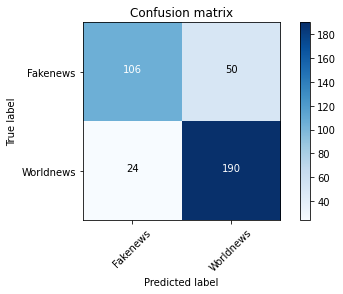

In [66]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_lstm_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

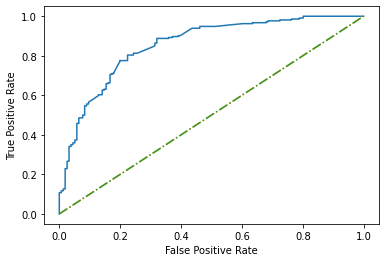

In [95]:
lstm_plot = plot_roc_curve_keras(model_lstm , X_test , y_test)

### 4.3 Visualising Most Wrong Predicted Reddit Post
___

In [97]:
y_proba = model_lstm.predict(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]

In [98]:
df_prediction_lstm  = pd.DataFrame({'Title' : X_test,
                                  'Target' : y_test,
                                  'Prediction' : tf.squeeze(tf.round(model_lstm_pred)),
                                  'Prediction_score' : fakenews_prediction})

In [99]:
# Visualing Most Wrong World News (LSTM Model)
# Note Prediction Score refer to the model predicting either 0 or 1, While Fakenews Score or worldnews score predict whether it is Fakenews or Worldnews

df_most_right_wrong_lstm = df_prediction_lstm[df_prediction_lstm['Target'] != df_prediction_lstm['Prediction']].sort_values(by = 'Prediction_score' , ascending = False)
df_most_right_wrong_lstm.tail(10)

,Title,Target,Prediction,Prediction_score
493,pg leprechaun rich,1,0.0,0.224759
463,iphon samsung cover,1,0.0,0.224759
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0.0,0.175324
568,happen gener facebook websit xml sitemap file,1,0.0,0.153800
1051,daili covid case like soon exceed next week crucial singapor,1,0.0,0.145568
1000,case regist asaduddin owaisi hate speech,1,0.0,0.126324
1123,girl rescu famili tri goug eye cannibalist black magic ritual coconut jakarta,1,0.0,0.092654
872,orfium project offic elstudio,1,0.0,0.081538
1069,pakistan report fresh coronaviru case death,1,0.0,0.076780
1346,facebook apolog put primat label video black men,1,0.0,0.070926


In [103]:
# Visualing Most Wrong Fake News (LSTM Model)
df_most_right_wrong_lstm.head(10)

,Title,Target,Prediction,Prediction_score
32,one day fewer hospit make trend especi less decreas,0,1.0,0.925224
74,afghan ambassador daughter bruis blood mark real,0,1.0,0.917089
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1.0,0.901509
261,pocahonta first winner hunger game,0,1.0,0.859900
814,polic vs hypocrisi polic offic could face death penalti shoot rayshard brook,0,1.0,0.841894
486,dutchi priminist mark prutten call absurd weed still illeg europ,0,1.0,0.819574
1330,thai seal murder cave rescu cover last year,0,1.0,0.814117
780,instagram girl accus cv la habra falsifi covid result,0,1.0,0.812345
373,due covid travel restrict american forc hold coup local year,0,1.0,0.808972
1236,acronym group sabotag iowa caucu birth billionair fund alabama disinform campaign,0,1.0,0.799411


### 4.4 Visualing Word Embedding
___

In [104]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
words_in_vocab = text_vectorizer.get_vocabulary()
embed_weights = model_lstm.get_layer('embedding').get_weights()[0]
embed_weights.shape

(120, 128)

In [105]:
# # Create a checkpoint from embedding, the filename and key are the
# # name of the tensor.
# log_dir = '/content/sample_data/'
# weights = tf.Variable(lstm_model.get_layer('embedding').get_weights()[0][1:])

# checkpoint = tf.train.Checkpoint(embedding=weights)
# checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

In [ ]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

#### 4.4.1 Embedding Projector for 120 Vocab for World and Fake News
___

* The explained variance for this clustering is around 45% , using a vocab limit of 120.
* The vocabs are more representative for our current quantity of data , which is around 2000 sentences.
* 2 clear distinct cluster could be observed : Trump on the fakenews side , and Afghanistan on the worldnews Side

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/fakenews_120vocab.PNG' width = 100%>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/worldnews_120vocab.PNG' width = 100%>

#### 4.4.2 Embedding Projector for 6000 Vocab for World and Fake News
___

* The explained variance for this clustering is around 22% , using a vocab limit of 6000.
* The vocabs are less representative for our current quantity of data , which is around 2000 sentences. The Vocab are more diluted across a smaller dataset , thus a lower explained variance observed.
* 2 clear distinct cluster could be observed : CNN on the fakenews side , and Afghanistan on the worldnews Side

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/fakenews_6000vocab.PNG' width = 100%>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/worldnews_6000vocab.PNG' width = 100%>

### 4.5 Visualing the word vectors
___

In [ ]:
sample_prediction = model_RFC.predict_proba([sample_sentence])
print(sample_prediction)

[[0.31699619 0.68300381]]


In [ ]:
sample_prediction = tf_model.predict([sample_sentence])
print(sample_prediction[0])

[0.5878673]


In [ ]:
word_list = ['trump' , 'articl' , 'real' , 'cnn' , 'broadcast' , 'propoganda' , 'afghanistan' , 'worker' , 'canada' , 'biden']
embed_list = []
embed_list = [embedding(text_vectorizer([word]))[0][0] for word in word_list]

In [ ]:
np.savetxt('embed.csv' , embed_list , delimiter=',')

In [ ]:
embed_list[0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.1259693 , -0.10247844, -0.0626225 ,  0.01311572, -0.10523386,
       -0.06750959,  0.02973633,  0.10132404,  0.05454994,  0.10168363,
       -0.10508119,  0.03876325, -0.1189834 ,  0.01470998, -0.08003558,
       -0.04107728, -0.11106404,  0.04368567,  0.05755809,  0.05098592,
        0.09630256, -0.11351807,  0.0470967 ,  0.10224249,  0.04977388,
        0.05017328, -0.08497125,  0.09461493,  0.09629349,  0.10293321,
        0.07935694,  0.06682357, -0.04779289, -0.07321245, -0.10324998,
        0.10472663,  0.04741828, -0.022199  , -0.07481779,  0.10816189,
       -0.0861986 ,  0.05303886,  0.07591061,  0.10156168,  0.12034938,
        0.05610571, -0.07424447, -0.10191513,  0.09697195,  0.10466328,
        0.10976049,  0.06749075,  0.12296402,  0.06218376,  0.12384447,
       -0.07351742,  0.04290383, -0.0164747 , -0.095693  , -0.10206821,
       -0.08010652, -0.07204276, -0.11940002, -0.10630439,  0.09630307,
        0.021283

In [ ]:
sample_sentence = 'man best friend shot woman'
sample_prediction = model_lstm.predict([sample_sentence])
print(sample_prediction[0])

[0.79083014]


# 5.0 Modelling with Tensorflow Universal Sentence Encoder
___

In [108]:
max_vocab_length = 120 # We have around 4848 from above visualisation
max_length = 30

text_vectorisation = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length = None,
                                       pad_to_max_tokens = True)

In [ ]:
# random_sentences = random.sample(df_main['title'].to_list() , 3)

# for sentence in random_sentences:
#   print(sentence)
#   print(embed([sentence]))
#   print('------------------------------------------------')

In [109]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'tf_model')

In [116]:
model_use = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

model_use.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = 'accuracy')

In [117]:
model_use.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_model (KerasLayer)        (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [119]:
history_tf = model_use.fit(X_train,
                         y_train,
                         epochs = 10,
                         validation_data = (X_test , y_test),
                         callbacks = [create_tensorboard_callback('model_log' , 'use_model')])

Saving Tensorboard log files to model_log/use_model/20210924-092511
Epoch 1/10
47/47 [==============================] - 1s 23ms/step - loss: 0.3656 - accuracy: 0.8450 - val_loss: 0.4100 - val_accuracy: 0.8189
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.3289 - accuracy: 0.8626 - val_loss: 0.4152 - val_accuracy: 0.8216
Epoch 3/10
47/47 [==============================] - 1s 15ms/step - loss: 0.2894 - accuracy: 0.8876 - val_loss: 0.4349 - val_accuracy: 0.8135
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.2542 - accuracy: 0.9039 - val_loss: 0.4445 - val_accuracy: 0.8027
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.2131 - accuracy: 0.9269 - val_loss: 0.4533 - val_accuracy: 0.8054
Epoch 6/10
47/47 [==============================] - 1s 15ms/step - loss: 0.1827 - accuracy: 0.9418 - val_loss: 0.4819 - val_accuracy: 0.8108
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1319 - accu

In [120]:
model_use_pred = model_use.predict(X_test)

### 5.2 Evaluating Universal Sentence Encoder Score
___

In [124]:
use_score = eval_classification(y_test , tf.squeeze(tf.round(model_use_pred)))
use_score

{'Accuracy': 0.8135135135135135,
 'F1 Score': 0.8406466512702078,
 'Precision': 0.8310502283105022,
 'Recall': 0.8504672897196262}

Confusion matrix, without normalization
[[119  37]
 [ 32 182]]


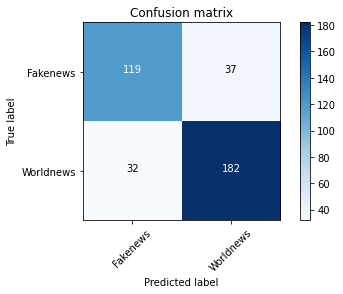

In [123]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_use_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

In [ ]:
plot_roc_curve_keras()

# 7.0 Modelling with TF BERT
___

In [ ]:
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/mnli/2')

In [ ]:
text_processed = bert_preprocess(['man best friend shot woman'])

In [ ]:
text_processed.keys()

dict_keys(['input_mask', 'input_type_ids', 'input_word_ids'])

In [ ]:
text_processed['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[ 101, 2158, 2190, 2767, 2915, 2450,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>

In [ ]:
bert_model = hub.KerasLayer(encoder_url)
bert_results = bert_model(text_processed)
bert_results.keys()

dict_keys(['default', 'encoder_outputs', 'sequence_output', 'pooled_output'])

In [ ]:
# Bert Layers
inputs = tf.keras.layers.Input(shape = () , dtype = tf.string , name = 'text')

x = bert_preprocess(inputs)
x = bert_encoder(x)

x = tf.keras.layers.Dropout(0.1 , name = 'dropout')(x['pooled_output'])
outputs = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name = 'output')(x)

model_bert = tf.keras.Model(inputs = inputs,
                            outputs = outputs)

In [ ]:
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
model_bert.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

In [ ]:
history_bert = model_bert.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'bert_model')])

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


ERROR:tensorflow:Failed to start profiler: Another profiler is running.


Saving Tensorboard log files to model_log/bert_model/20210923-125827
Epoch 1/5
 1/47 [..............................] - ETA: 47s - loss: 0.6449 - accuracy: 0.6562WARNING:tensorflow:Trace already enabled


ERROR:tensorflow:Failed to start profiler: Another profiler is running.


ERROR:tensorflow:Failed to start profiler: Another profiler is running.


47/47 [==============================] - 51s 1s/step - loss: 0.6594 - accuracy: 0.6087 - val_loss: 0.6356 - val_accuracy: 0.6270
Epoch 2/5
47/47 [==============================] - 45s 964ms/step - loss: 0.6342 - accuracy: 0.6405 - val_loss: 0.6230 - val_accuracy: 0.6378
Epoch 3/5
47/47 [==============================] - 46s 988ms/step - loss: 0.6044 - accuracy: 0.6669 - val_loss: 0.6109 - val_accuracy: 0.6595
Epoch 4/5
47/47 [==============================] - 50s 1s/step - loss: 0.5842 - accuracy: 0.6940 - val_loss: 0.6029 - val_accuracy: 0.6432
Epoch 5/5
47/47 [==============================] - 53s 1s/step - loss: 0.5740 - accuracy: 0.7150 - val_loss: 0.5966 - val_accuracy: 0.6541


In [ ]:
model_bert_pred

Confusion matrix, without normalization
[[ 75  81]
 [ 47 167]]


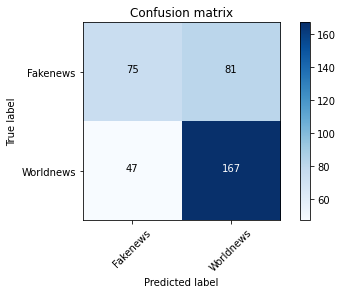

In [ ]:
model_bert_pred = model_bert.predict(X_test)
eval_classification(y_test , tf.squeeze(tf.round(model_bert_pred)))

cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_bert_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

In [ ]:
eval_classification(y_true=y_test , y_pred = tf.squeeze(tf.round(model_bert_pred)))

{'Accuracy': 0.654054054054054,
 'F1 Score': 0.7229437229437229,
 'Precision': 0.6733870967741935,
 'Recall': 0.780373831775701}

In [ ]:
sample_sentence = 'man best friend shot woman'
sample_prediction = model_bert.predict([sample_sentence])
print(sample_prediction[0])

[0.2804184]


### 6.1 Visualing Bert Model
___

In [ ]:
# See BERT paper: https://arxiv.org/pdf/1810.04805.pdf
# And BERT implementation convert_single_example() at https://github.com/google-research/bert/blob/master/run_classifier.py

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

NameError: ignored

In [ ]:
stokens_list = []
input_ids = []
input_masks = []
input_segments = []
for s in X:
    stokens = tokenizer.tokenize(s)
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    stokens_list.append(stokens)
    input_ids.append(get_ids(stokens, tokenizer, max_seq_length))
    input_masks.append(get_masks(stokens, max_seq_length))
    input_segments.append(get_segments(stokens, max_seq_length))

NameError: ignored